In [283]:
# Módulos
import numpy as np
import control as ct
import controle as ctl
# Cálculo de Parâmetros
NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop
####
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)
####
print("ζ: ", round(z, 3))# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
Tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
Tp_ms = 1e3*Tp
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("Tp: ", round(Tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)
print("ω: ", round(w, 3))

ζ:  0.407
Mp:  24.69 %
Tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms
ω:  150.646


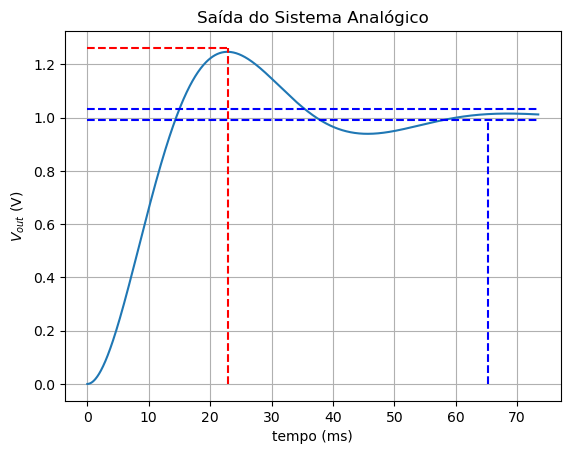

In [284]:
import matplotlib.pyplot as plt
import control as ct

s = ct.tf('s')
t = np.linspace(0, (Ts+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = w2/(s**2 + s*2*z*w + w2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Analógico")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=Tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=Tp])), 'r--')
plt.plot([Tp*1e3, Tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ys  = y[np.abs(y - y[-1]*(1-2e-2)) <= 1e-5]
plt.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')
plt.savefig("Analogico.svg", format="svg")

0 states have been removed from the model

   0.349 z + 0.2653
----------------------
z^2 - 0.835 z + 0.4493

dt = 0.006527999999999997



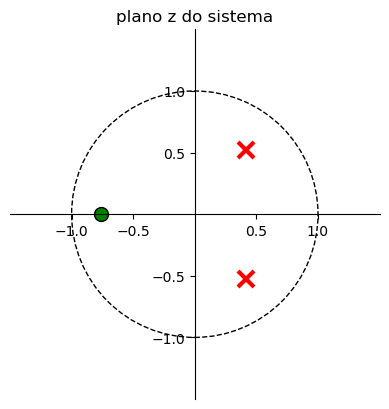

In [285]:
from matplotlib import rcParams
from matplotlib.figure import Figure
from matplotlib import patches

Ta = Ts/10
Gz = ct.minreal(ct.c2d(G, Ta))
print(Gz)
ctl.zplane(Gz)
plt.show()

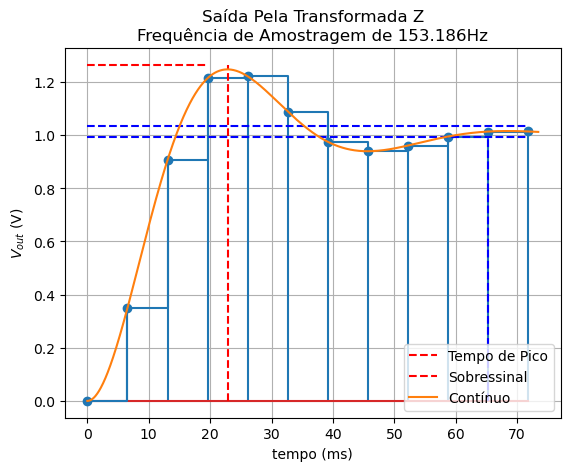

In [286]:
tz = np.arange(0, (Ts+τ/2), Ta)
ax, tz, yz = ctl.plot_step(Gz, tz, xl="tempo (ms)", yl="$V_{out}$ (V)",
                   title="Saída Pela Transformada Z\nFrequência de Amostragem de " + str((round(1/Ta,3))) + "Hz")
###
# Sobressinal
ax.plot([Tp_ms, Tp_ms], [0, yz[-1]*(1+Mp)], "r--", label="Tempo de Pico")
ax.plot(1e3*tz[tz<=Tp], yz[-1]*(1+Mp)*np.ones(len(tz[tz<=Tp])), "r--", label="Sobressinal")
# Tempo de Acomodação (2%)
ax.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
# Valor de Acomodação (2%)
ax.plot(1e3*tz, np.ones(len(yz))*yz[-1]*(1-2e-2), 'b--')
ax.plot(1e3*tz, np.ones(len(yz))*yz[-1]*(1+2e-2), 'b--')
# Valor Contínuo Simulado por G
ax.plot(tms, y, label="Contínuo")
plt.legend(loc = "lower right")
plt.show()

In [287]:
# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("tp: ", round(tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)

Mp:  24.69 %
tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms


b = [0.34899172 0.26529613]
a = [ 1.         -0.83504112  0.44932896]


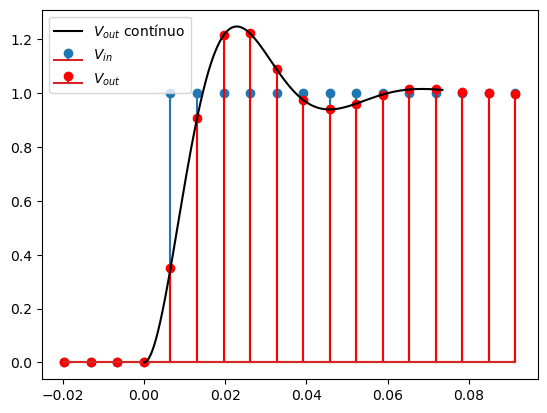

In [288]:
import scipy.signal as sp

b = Gz.num[0][0]
a = Gz.den[0][0]

print("b =", b)
print("a =", a)
# Verificando Coeficientes
tz = np.arange(-len(a)*Ta, (Ts+2*τ), Ta)
x  = np.heaviside(tz, 0) # degrau
xa = 0 # Acumula b[0]*x[k] + ... + b[n]*x[k-n]
ya = 0 # Acumula a[1]*y[k-1] + ... + a[n]*y[k-n]
yf = np.zeros(len(tz))
n0 = len(a)
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    j = 0
    xa=0
    ya=0
    for bn in b:
        xa = xa + bn*x[n-j]
        j  = j+1
    j = 1
    for an in a[1:]:
        ya = ya + an*yf[n-j]
        j = j+1
    yf[n] = (xa-ya)/a[0]
    n = n+1

plt.stem(tz, x, label="$V_{in}$")
plt.stem(tz, yf, "r", label="$V_{out}$")
plt.plot(t, y, "k", label="$V_{out}$ contínuo")
plt.legend()
plt.show()

## Ajustando C(z) por Root Locus

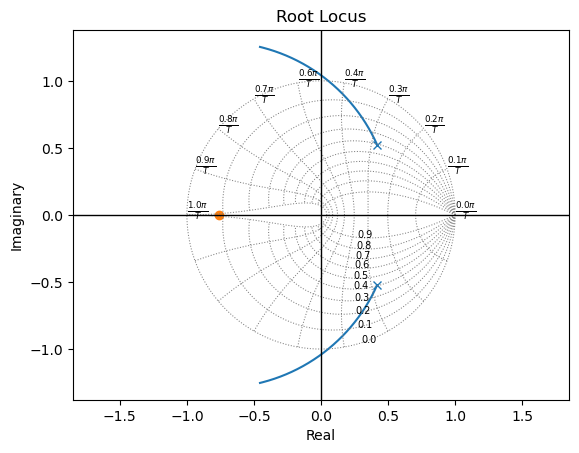

In [289]:
z = ct.tf('z')
k = np.linspace(0, 5, 1000)
root_locus = ct.root_locus(Gz, kvect=k)
plt.show()

In [290]:
# Ts 5% = NT*1e-3
# Erro nulo ao degrau
# Mp = 2*NT/100
Ts5 = NT*1e-3
Mp  = 2*NT/100
# Zeta e Omega do sistema controlado
ζ   = -np.log(Mp)/np.sqrt(np.pi**2 + np.log(Mp))
ω   = 3/(ζ*Ts)
ζ   = 0.5
ω   = 4
ωd  = ω*np.sqrt(1-ζ**2)
##
j  = complex(0, 1)
s1 = -ζ*ω+j*ωd
z1 = np.exp(s1*Ta)
print("Pólo desejado:", z1)
## Adicionando ZOH e transformando G(s)
s   = ct.tf('s')
z   = ct.tf('z')
ZOH = 1-z**(-1)
Gz  = ct.minreal(ct.c2d(G, Ta))
print(Gz)

Pólo desejado: (0.9867764984810586+0.022318428147517572j)
0 states have been removed from the model

   0.349 z + 0.2653
----------------------
z^2 - 0.835 z + 0.4493

dt = 0.006527999999999997



## Analisando Plano z para determinar local do zero

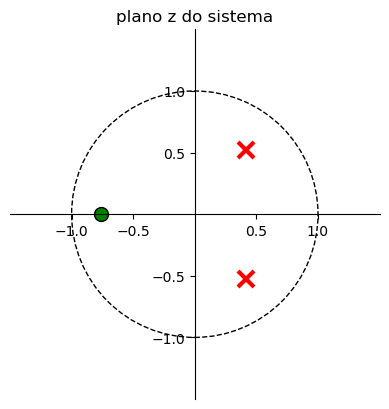

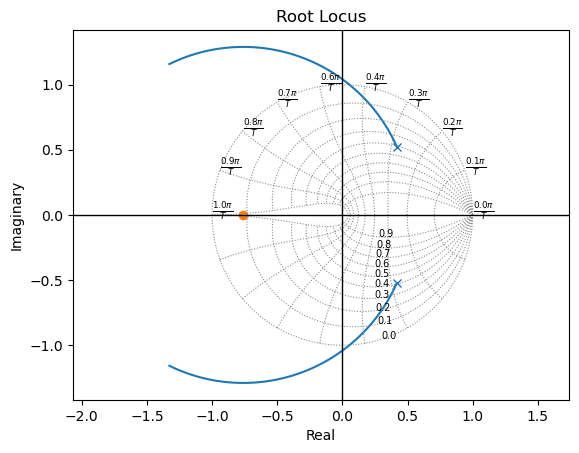

In [296]:
ctl.zplane(Gz)
plt.show()
k = np.linspace(0, 10, 100)
ct.root_locus(Gz, k)
plt.show()

Para melhorar a resposta transitória, foi escolhido um zero na origem, $\alpha=0$

0 states have been removed from the model


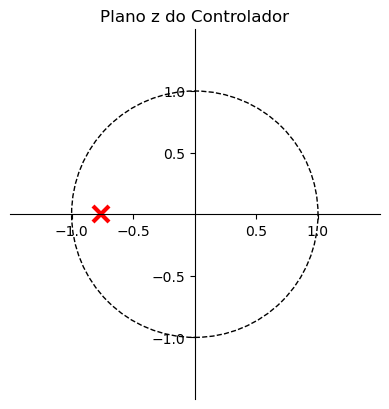

α: -2.309126680628414
β: (0.7601788821589508-0j)
K: 1.2980010644835336

z - 2.309
----------
z + 0.7602



In [304]:
α = 0
# Calcula ângulo que z1 deve adicionar ao sistema
ang = 0
aGz = ct.minreal(Gz)
for zero in aGz.zeros():
    ang = ang + np.arctan2(z1.imag - zero.imag, z1.real - zero.real)
for pole in aGz.poles():
    ang = ang - np.arctan2(z1.imag - pole.imag, z1.real - pole.real)
##
ang = (np.pi+ang)
print("ang:", (180/np.pi)*ang)
fi1 = np.arctan2(-α.real - z1.real, z1.imag-α.imag)
print("fi1:", (180/np.pi)*fi1)
fi2 = -fi1 - ang
print("fi2:", (180/np.pi)*fi2)
# fi2 = np.arctan2(-β.real - z1.real, z1.imag+β.imag)
# np.tan(fi2) = (-β - z1.real)/(z1.imag-0)
# z1.imag*np.tan(fi2) = -β - z1.real
# β = -(z1.imag*np.tan(fi2) + z1.real)
β   = -(z1.imag * np.tan(-fi2) + z1.real) # => Adição angular de um polo é invertida
#np.angle(z1+β) = np.angle(z1+α) - ang
Cz  = (z+α)/(z+β)
ctl.zplane(Cz, title="Plano z do Controlador")
plt.show()
#################################
#        b[0] + ... + b[n]z**-n #
# G(z) = ---------------------- #
#        a[0] + ... + a[n]z**-n #
#################################
#
#|K * C(z)G(z)|z->z1=1
# K = 1/(C(z1)G(z1))
#
K = np.abs((np.polyval(a, z1)*(z1+β))/
           (np.polyval(b, z1)*(z1+α)))
print("α:", α)
print("β:", β)
print("K:", K)
print(Cz)

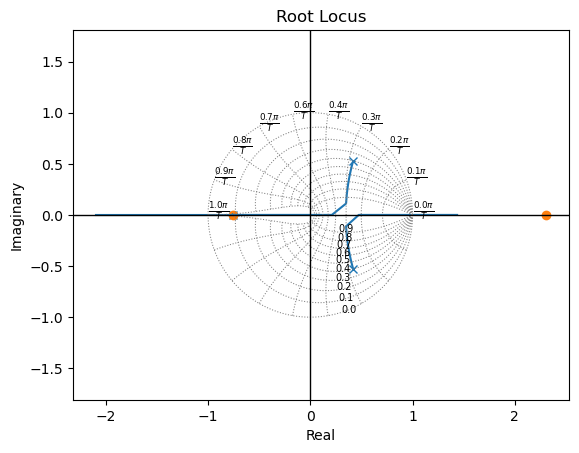

c:\Users\emanuel\anaconda3\Lib\site-packages\control\statesp.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


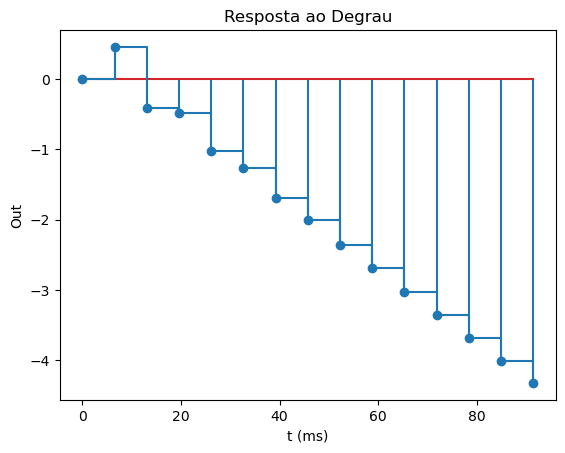

In [305]:
k = np.linspace(0, K+3, 100)
ct.root_locus(Cz*Gz, k)
plt.show()
ctl.plot_step(ct.feedback(K*Cz*Gz, 1), t=np.arange(0, (Ts+2*τ), Ta))
plt.grid()
plt.show()